# <center><b>FaKe/Prototype: An Investigation into Fake News Detection Models With A Filipino Corpus</b></center>

### <div style="text-align: center;">**JOCSING, Rene Andre**<br>**LUPAC, Coebe Austin**<br>**NARAGDAO, Ron Gerlan**</div>


# **Fake News**

*   Type of **propaganda or yellow journalism**

*   Deliberate misinformation **spread via print media, broadcast media, or online media** (Leonhardt & Thompson, 2017)

*   Misinformation ranks among the **world’s top global risks** as fake news outlets see astounding traffic and engagement. (World Economic Forum, 2018)

*   Fake news **costs the global economy a baffling 78 billion USD**. (Siar, 2021; CHEQ, n.d.)

*   **51% of Filipinos** find it difficult to spot fake news. (Felix, Sanchez II, & Curato, 2023)

# **Problem Statement**

* Machine learning (ML) models have made great strides in distinguishing between fake and authentic news.

* Cruz, Tan, and Cheng (2020) has pioneered the first Filipino news dataset with 3,206 expertly labelled news articles and benchmarks transfer learning ML techniques to train robust fake news classifiers from a relatively small amount of data.

* The models (deep learning models) that they investigate, although effective, cannot be easily deployed for consumer-level applications.



# **Research Objectives**

### **General Objective**

We attempt to investigate traditional ML models that may provide adequate performance in distinguishing between fake and authentic Filipino news articles.

### **Specific Objectives**

* To train ML models in distinguishing between fake and authentic multi-domain Filipino news articles;

* To determine the model with the best performance.

# **Scope and Limitations of the Research**

In this study, we will investigate traditional machine learning models, excluding pre-trained and deep learning ones. We constrain the machine learning models that we will use in the study to a low-resource dataset, Fake News Filipino (Cruz,
Tan, & Cheng, 2023). To identify the model(s) that exhibit the best performance, we will use accuracy as the metric for ranking.

# **Significance of the Research**

Our study builds on the work of Cruz et al. (2020), by investigating simpler traditional
machine learning models that may accurately distinguish between fake and authentic Filipino news articles.

# **Model Training**

### Resource Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Imports

In [ ]:
import pandas as pd
import numpy as np

import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from datetime import datetime

import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from tokenizers import Tokenizer

from json import load as js_load

#   Suppress specific warning about tokenize_pattern from sklearn.feature_extraction.text
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")

#   Preamble, load external files
global tokenizer
tokenizer = Tokenizer.from_file("/content/drive/Shareddrives/Colab_Notebooks/CMSC197/roberta-tagalog-large/tokenizer.json")

nltk.data.path.append('/content/drive/Shareddrives/Colab_Notebooks/CMSC197/nltk')

### Transformers (Feature Extractors)

In [ ]:
#   Filipino linguistic feature extractors adapted from: https://github.com/imperialite/filipino-linguistic-extractors
%cd /content/drive/Shareddrives/Colab_Notebooks/CMSC197/filipino-linguistic-extractors

import SYLL as SYLL
import TRAD as TRAD

from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np

#   Custom transformer for TRAD feature extraction
class TRADExtractor(BaseEstimator, TransformerMixin):
    def word_count_per_doc(self, text):
        return TRAD.word_count_per_doc(text)

    def sentence_count_per_doc(self, text):
        return TRAD.sentence_count_per_doc(text)

    def polysyll_count_per_doc(self, text):
        return TRAD.polysyll_count_per_doc(text)

    def ave_word_length(self, text):
        return TRAD.ave_word_length(text)

    def ave_phrase_count_per_doc(self, text):
        return TRAD.ave_phrase_count_per_doc(text)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for doc in X:
            word_count = self.word_count_per_doc(doc)
            sentence_count = self.sentence_count_per_doc(doc)
            polysyll_count = self.polysyll_count_per_doc(doc)
            ave_word_length = self.ave_word_length(doc)
            ave_phrase_count = self.ave_phrase_count_per_doc(doc)
            features.append([word_count, sentence_count, polysyll_count, ave_word_length, ave_phrase_count])
        return np.array(features)

#   Custom transformer for SYLL feature extraction
class SYLLExtractor(BaseEstimator, TransformerMixin):
    def get_cc_cluster(self, text):
        return SYLL.get_consonant_cluster(text)

    def get_v_density(self, text):
        return SYLL.get_v(text)

    def get_cv_density(self, text):
        return SYLL.get_cv(text)

    def get_vc_density(self, text):
        return SYLL.get_vc(text)

    def get_cvc_density(self, text):
        return SYLL.get_cvc(text)

    def get_vcc_density(self, text):
        return SYLL.get_vcc(text)

    def get_cvcc_density(self, text):
        return SYLL.get_cvcc(text)

    def get_ccvcc_density(self, text):
        return SYLL.get_ccvcc(text)

    def get_ccvccc_density(self, text):
        return SYLL.get_ccvccc(text)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for doc in X:
            cc_cluster = self.get_cc_cluster(doc)
            v_density = self.get_v_density(doc)
            cv_density = self.get_cv_density(doc)
            vc_density = self.get_vc_density(doc)
            cvc_density = self.get_cvc_density(doc)
            vcc_density = self.get_vcc_density(doc)
            cvcc_density = self.get_cvcc_density(doc)
            ccvcc_density = self.get_ccvcc_density(doc)
            ccvccc_density = self.get_ccvccc_density(doc)
            features.append([
                cc_cluster, v_density, cv_density, vc_density, cvc_density,
                vcc_density, cvcc_density, ccvcc_density, ccvccc_density
            ])
        return np.array(features)

/content/drive/Shareddrives/Colab_Notebooks/CMSC197/filipino-linguistic-extractors


### BPE Tokenizer

In [ ]:
#   Wrapper around pre-trained BPE Tokenizer from Cruz et al. at: https://huggingface.co/jcblaise/roberta-tagalog-large/tree/main
def bpe_tokenizer(doc):
    return tokenizer.encode(doc).tokens

### Loading + Setup of Dataset

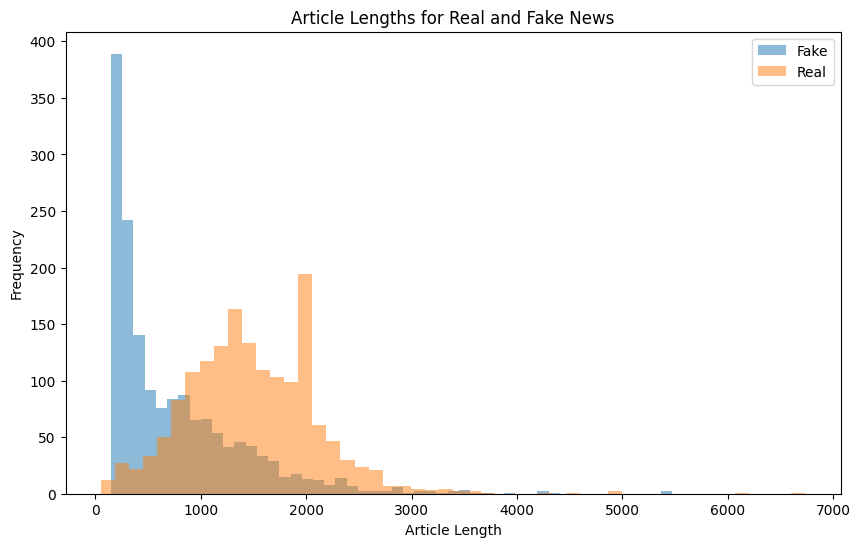

In [ ]:
#   Load Fake News Filipino by Cruz et al. dataset adapted from: https://github.com/jcblaisecruz02/Tagalog-fake-news
data = pd.read_csv("/content/drive/Shareddrives/Colab_Notebooks/CMSC197/full.csv")

#   Split the data into features (X) and labels (y)
X = data['article']
y = data['label']  # Labels are 0 -> Fake or 1 -> Real, with a perfect 50/50 split between the two classes (balanced dataset)

#   Calculate article lengths
data['article_length'] = data['article'].apply(len)

#   Plot histograms for real and fake news
plt.figure(figsize=(10, 6))
plt.hist(data[data['label'] == 0]['article_length'], bins=50, alpha=0.5, label='Fake')
plt.hist(data[data['label'] == 1]['article_length'], bins=50, alpha=0.5, label='Real')
plt.title('Article Lengths for Real and Fake News')
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#   Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Classifiers

In [ ]:
#   Classifiers to train
classifiers = [
    {
        'name': 'Multinomial Naive Bayes',
        'model': MultinomialNB(),
        'params': {
            'classifier__alpha': [0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(max_iter=2000, n_jobs=-1),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(n_jobs=-1),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [10, 20],
            'classifier__min_samples_split': [2, 5]
        }
    },
    {
        'name': 'SVC',
        'model': SVC(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__kernel': ['linear', 'rbf']
        },
        'n_jobs': -1
    },
    {
        'name': 'Voting Classifier',
        'model': VotingClassifier(estimators=[
            ('lr', LogisticRegression(max_iter=2000, solver='liblinear')),
            ('rf', RandomForestClassifier(n_jobs=-1)),
            ('svc', SVC(probability=True))
        ]),
        'params': {
            'voting': ['hard', 'soft']
        }
    }
]

### Training Without Gridsearch

In [ ]:
#   Train classifiers with no gridsearch
print("CLASSIFIERS WITHOUT GRIDSEARCH")

for clf_info in classifiers:
    print(f"\nTraining Model: {clf_info['name']}")
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), tokenizer=bpe_tokenizer)),        #   Get unigrams, bigrams, and trigrams
            ('bow', CountVectorizer()),                                                     #   Get bag of words
            ('trad', TRADExtractor()),                                                      #   Extract TRAD features
            ('syll', SYLLExtractor())                                                       #   Extract SYLL features
        ])),
        ('classifier', clf_info['model'])
    ])

    #   Fit the entire pipeline on the training data
    pipeline.fit(X_train, y_train)

    #   Make predictions
    y_pred = pipeline.predict(X_test)

    #   Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    #   Classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    #   Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {clf_info["name"]}')
    plt.show()


### Results:



CLASSIFIERS WITHOUT GRIDSEARCH

<br>
Training Model: Multinomial Naive Bayes <br>
Accuracy: 0.5529595015576324 <br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 1.00      | 0.11   | 0.19     |
| 1         | 0.53      | 1.00   | 0.69     |
| Accuracy  |           |        | 0.55     |


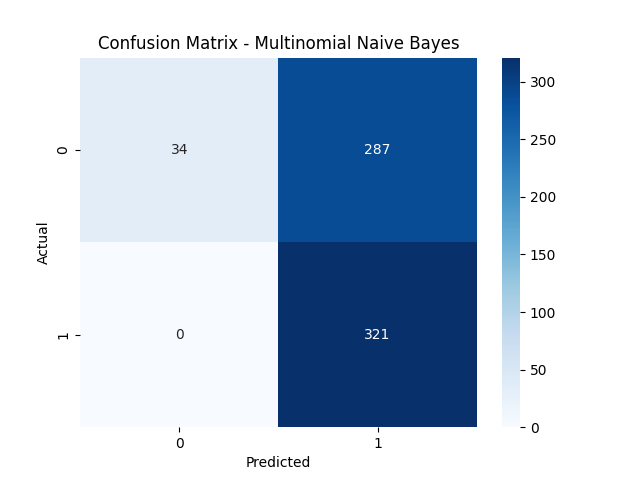

<br>
Training Model: Logistic Regression <br>
Accuracy: 0.9735202492211839 <br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.96      | 0.98   | 0.97     |
| 1         | 0.98      | 0.96   | 0.97     |
| Accuracy  |           |        | 0.97     |


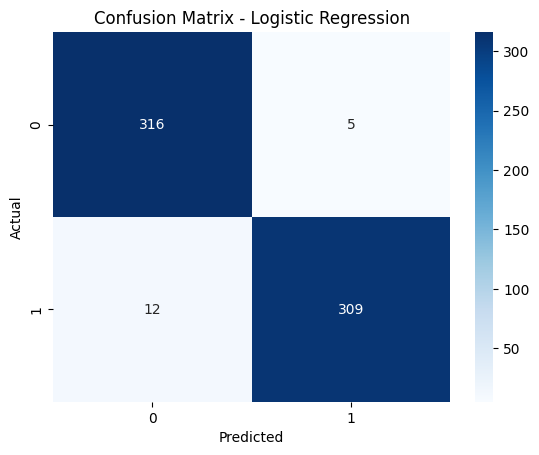

<br>
Training Model: Random Forest <br>
Accuracy: 0.9501557632398754 <br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.94      | 0.96   | 0.95     |
| 1         | 0.96      | 0.94   | 0.95     |
| Accuracy  |           |        | 0.95     |


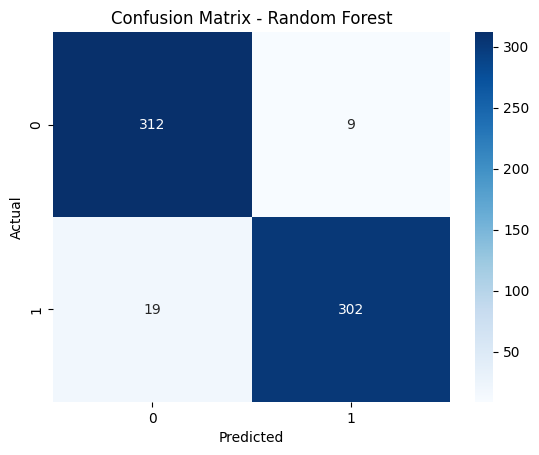

<br>
Training Model: SVC <br>
Accuracy: 0.780373831775701 <br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.84      | 0.69   | 0.76     |
| 1         | 0.74      | 0.87   | 0.80     |
| Accuracy  |           |        | 0.78     |


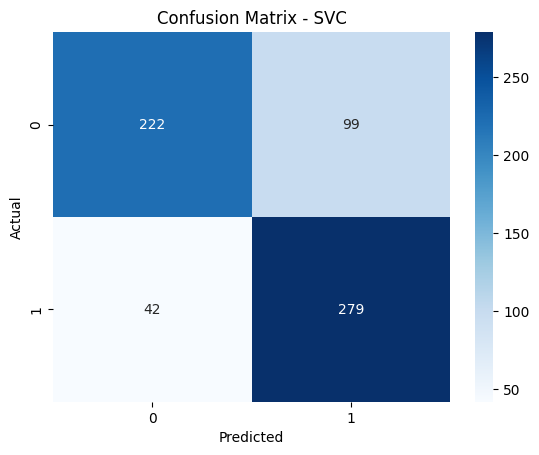

<br>
Training Model: Voting Classifier <br>
Accuracy: 0.9595015576323987 <br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.95      | 0.97   | 0.96     |
| 1         | 0.97      | 0.95   | 0.96     |
| Accuracy  |           |        | 0.96     |

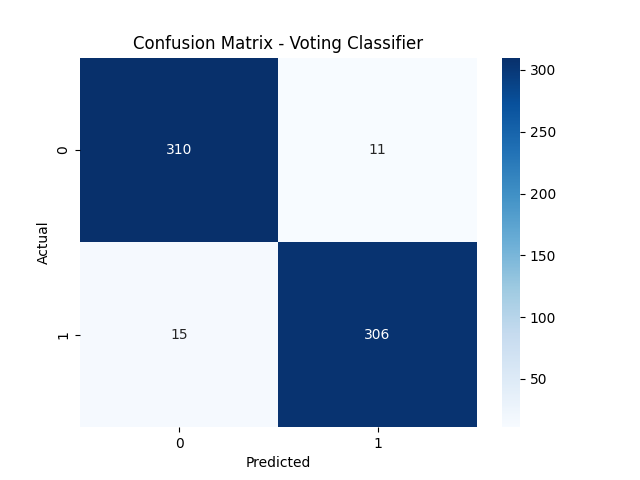

### Training With Gridsearch

In [ ]:
#   Train classifiers with gridsearch
print("CLASSIFIERS WITH GRIDSEARCH")

for clf_info in classifiers:
    print(f"\nTraining {clf_info['name']}")
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), tokenizer=bpe_tokenizer)),        #   Get unigrams, bigrams, and trigrams
            ('bow', CountVectorizer()),                                                     #   Get bag of words
            ('trad', TRADExtractor()),                                                      #   Extract TRAD features
            ('syll', SYLLExtractor())                                                       #   Extract SYLL features
        ])),
        ('classifier', clf_info['model'])
    ])

    #   Perform grid search
    grid_search = GridSearchCV(pipeline, clf_info['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    #   Make predictions
    y_pred = grid_search.predict(X_test)

    #   Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    #   Classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {clf_info["name"]}')
    plt.show()

# Results

CLASSIFIERS WITH GRIDSEARCH

<br>
Training Multinomial Naive Bayes<br>
Best Estimator for Multinomial Naive Bayes:<br>
Best Feature/s: alpha=0.1<br>

Accuracy: 0.9283489096573209<br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.99      | 0.87   | 0.92     |
| 1         | 0.88      | 0.99   | 0.93     |
| Accuracy  |           |        | 0.93     |

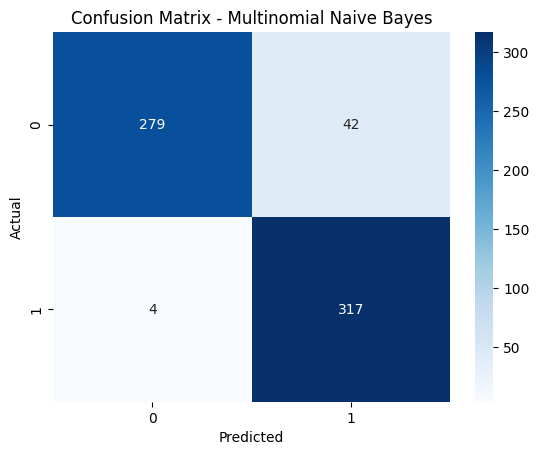


Training Logistic Regression<br>
Best Estimator for Logistic Regression:<br>
Best Feature/s: max_iter=2000<br>

Accuracy: 0.9735202492211839<br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.96      | 0.98   | 0.97     |
| 1         | 0.98      | 0.96   | 0.97     |
| Accuracy  |           |        | 0.97     |

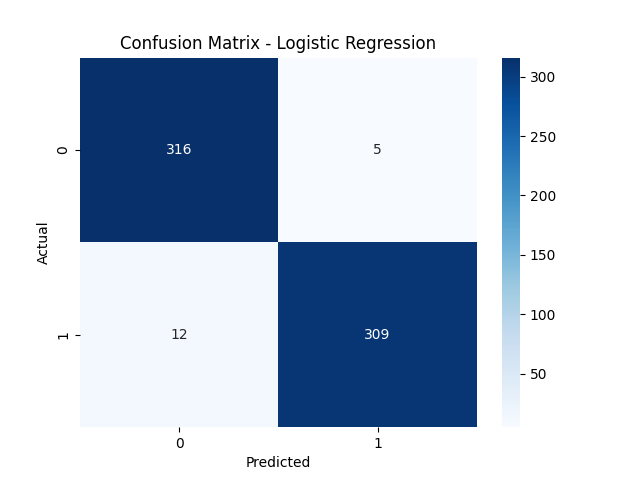


Training Random Forest<br>
Best Estimator for Random Forest:<br>
Best Feature/s: max_depth=20, n_estimators=50<br>

Accuracy: 0.9221183800623053<br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.91      | 0.93   | 0.92     |
| 1         | 0.93      | 0.91   | 0.92     |
| Accuracy  |           |        | 0.92     |

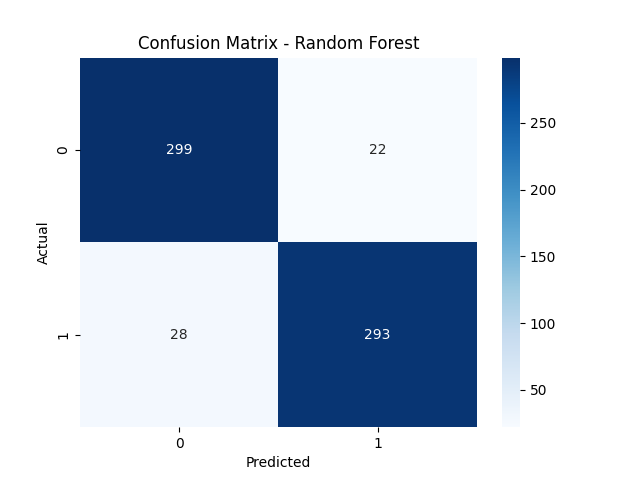

Training SVC<br>
Best Estimator for SVC:<br>
Best Feature/s: C=0.1, kernel='linear'<br>

Accuracy: 0.9704049844236761<br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.96      | 0.98   | 0.97     |
| 1         | 0.98      | 0.96   | 0.97     |
| Accuracy  |           |        | 0.97     |

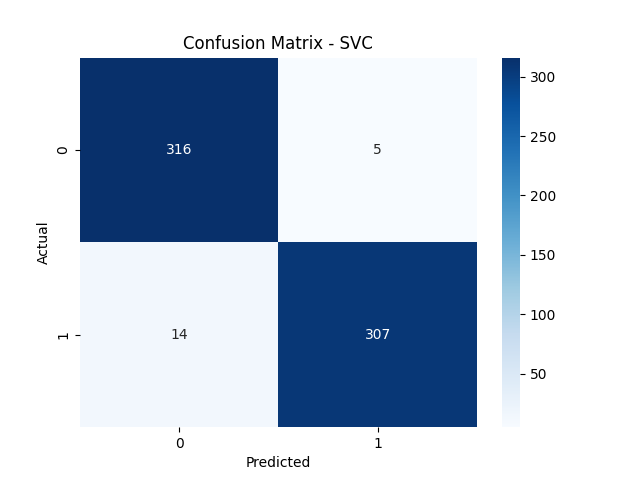

Training Voting Classifier<br>
Best Estimator for Voting Classifier:<br>
Best Feature/s: voting='soft'<br>

Accuracy: 0.9719626168224299<br>
Classification Report:

|           | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| 0         | 0.96      | 0.98   | 0.97     |
| 1         | 0.98      | 0.96   | 0.97     |
| Accuracy  |           |        | 0.97     |

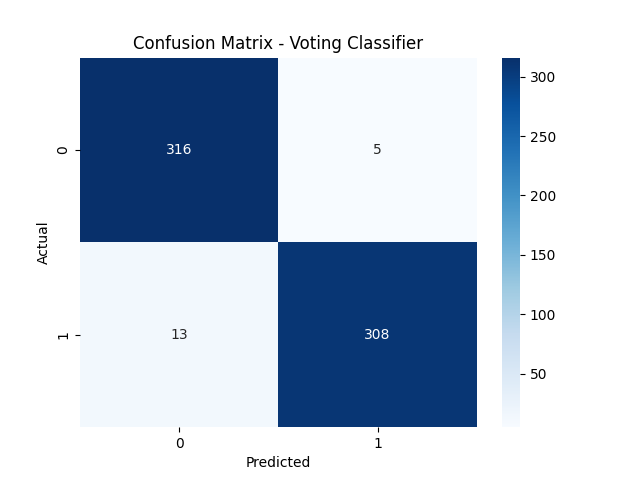

### Classifiers without Grid Search

**Multinomial Naive Bayes** has an accuracy of approximately 0.55. It has the lowest recall for class 0 of 0.11, signifying difficulty in identifying true instances of fake news. The f1-score of class 1 and 0 is 0.69 and 0.19, respectively, which are relatively low.

**Logistic Regression** has an accuracy of approximately 0.97. It has a high recall for class 1 of 0.96. Both class 1 and 0 have 0.97 f1-score.

**Random Forest** has an accuracy of approximately 0.95. It has a high recall for class 1 of 0.94. The f1-score of both classes is 0.96. Both classes in this method show balanced metrics.

**SVC** has an accuracy of approximately 0.78. It has a lower recall for class 0 of 0.69. The f1-score of class 1 and 0 is 0.80 and 0.76, respectively. SVC has a slight imbalance in precision and recall for both classes.

Our **Voting Classifier** has an accuracy of approximately 0.96. The recall of both class 1 and 0 is 0.96. The f1-score of both class 1 and 0 is also 0.96. Similar to Random Forest, both classes in this method also show balanced metrics.

### Classifiers with Grid Search

**Multinomial Naive Bayes** has an accuracy of approximately 0.93. It has the lowest recall for class 0 at 0.87. However, this score is still relatively high. The minimum f1-score of both classes is 0.92 with the best feature as alpha=0.1. Hyperparameter tuning in MultinomialNB has significantly improved balance between precision and recall for both classes.

**Logistic Regression**, on the other hand, has an accuracy of approximately 0.97, which is still the same as before applying grid search. It still has a high recall for class 1 of 0.96. Both classes have 0.97 f1-score. It has provided the best features of max_iter=2000.

**Random Forest** has an accuracy of approximately 0.92. It has a high recall for class 1 of 0.93. Both classes have 0.94 f1-score. In hyperparameter tuning, its best features are max_depth=20 and n_estimators=50. Still, with hyperparameter tuning, it provides the same balanced performance with minimal improvements.

**SVC** has an accuracy of approximately 0.97. It has a high recall for class 1 of 0.96. Both of the classes have 0.97 f1-score. In tuning SVC, the best features are C=0.1 and kernel='linear'.

**Voting Classifier** has an accuracy of approximately 0.97. It has the recall for class 1 of 0.96. Both the classes have 0.97 f1-score. In our Voting Classifier, the best feature is voting='soft'.

# Summary

Before applying grid search, there are two models that perform lowest in accuracy. SVC has an accuracy of approx. 0.78, and Multinomial NB has a poorer accuracy score of approx. 0.55. The rest of the models, Logistic Regression, Random Forest, and Voting Classifier, show an accuracy above approx 0.95. With respect to recall, Multinomial NB has the lowest recall of 0.11 in class 0 followed by SVC with a recall of 0.69, also in class 0.

After applying grid search, the accuracy of the lowest models mentioned have improved by around 40%. In addition, the other models also have their accuracy increased but not significantly. In this stage, all of the machine learning models now have an accuracy of above 0.90. These improvements depend on the parameters provided during hyperparameter tuning.






# Insights

Comparing the performances before and after application of grid search, the Logistic Regression model proved to be consistent in terms of accuracy, precision, recall, and f1-store. Random Forest shows a non-significant fluctuation in precision, recall, f1-score, and accuracy due to different trees being made everytime. Multinomial NB and SVC significantly improved. Lastly, Voting Classifier shows less significantly improved performance with the use of soft voting.

The use of grid search has a significant role in improving the performance of each models, especially Multinomial Naive Bayes and Support Vector Classifier. Thus, fine-tuning hyperparameters may enhance model effectiveness in the context of Filipino fake news detection.

The recall for class 0 in Multinomial Naive Bayes struggles with low percentage if not tuned well. Thus, an untuned MultinomialNB model method has difficulties in identifying true Filipino fake news instances. Further investigation into hyperparameters and improvements may be beneficial.

The Support Vector Classifier can still be considered for its decent performance with slight imbalance of precision and recall. Similar to Multinomial Naive Bayes, further exploration of the model's kernels and hyperparameters can be done.

The Voting Classifier that is an ensemble of Logistic Regression, Random Forest, and Support Vector Classifier also achieved competitive results. As Logistic Regression is included, we suspect that this is the source of its effectiveness.

# Conclusion

The results before applying grid search shows the weaknesses of Multinomial NB, showing an accuracy of 0.55 and lowest recall of 0.11. We improve all of the machine learning methods with grid search. Hyperparameter tuning yields significant improvements on the lowest accuracy models but non-significant improvements on the rest of the models that have already high accuracy.

Among the machine learning methods used, Logistic Regression showed consistently strong performance before and after applying grid search. Thus, we consider it as the primary model for future deployment. Since there are misclassifications from models that have class imbalances, investigations into more linguistic features should be considered. Further experimentation with hyperparameter tuning may yield potential improvements.

The chosen model may perform well in real-life scenario due to our findings. However, computational efficiency and deployment should be evaluated and considered. Still, we believe it is difficult to score an acccuracy above 0.97 due to our use of traditional machine learning models and our low-resource dataset. We also believe that our high-accuracy models are, in reality, overfitting the data due to the relatively small size of the dataset (only 3206 articles written in Filipino, with a perfect 50/50 split between the number of fake and real news).

For future study, we recommend to expand the dataset to mitigate overfitting and to investigate more complex hyperparameter tuning.